In [1]:
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from pathlib import Path
from random import sample

from utils.data import (parse_json, read_json, generate_dataset, 
                        BeneTech, collate_fn, ID2LABELS, get_transform)
from utils.dataset import show_boxes
from utils.engine import non_max_suppression, train_one_epoch

import torch
import torchvision
import torchvision.transforms as T
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN_MobileNet_V3_Large_FPN_Weights, fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
annot_dir = "datasets/benetech/train/annotations"
annots = [str(i) for i in Path(annot_dir).glob("*.json")]
len(annots)

360

In [4]:
img_dir = "datasets/benetech/train/images/"
imgs = [str(i) for i in Path(img_dir).glob("*.jpg")]
len(imgs)

360

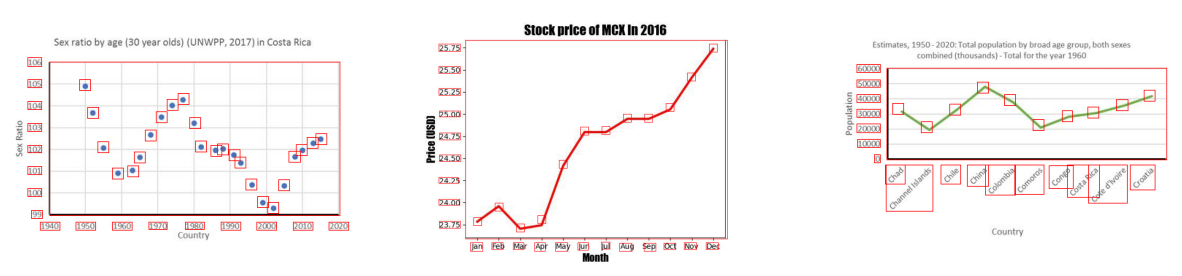

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

idxs = sample(range(len(annots)), 3)

show_boxes(json_file=annots[idxs[0]], ax=axs[0])
show_boxes(json_file=annots[idxs[1]], ax=axs[1])
show_boxes(json_file=annots[idxs[2]], ax=axs[2])

In [6]:
# # generate dataset
# generate_dataset(annot_dir, save_dir="datasets/dataset/", 
#                  random_state=43, mini=60000)

In [10]:
train_dir = "datasets/benetech/train/"
val_dir = "datasets/benetech/val/"
test_dir = "datasets/benetech/test/"

In [11]:
# create dataset splits
train_transforms = get_transform()
test_transforms = get_transform()

train_data = BeneTech(dataset_dir=train_dir, transforms=train_transforms)
val_data = BeneTech(dataset_dir=val_dir, transforms=test_transforms)
test_data = BeneTech(dataset_dir=test_dir, transforms=test_transforms)

In [12]:
# dataloaders
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False, collate_fn=collate_fn, num_workers=2)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False, collate_fn=collate_fn, num_workers=2)

In [13]:
data_iter = iter(train_loader)
imgs, targets = next(data_iter)

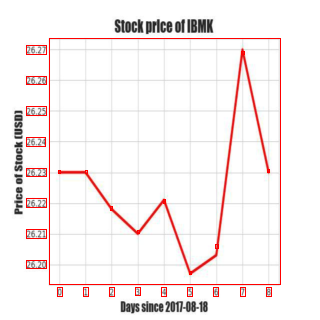

In [14]:
idx = 7
target = targets[idx]
img = T.ConvertImageDtype(torch.uint8)(imgs[idx])
boxes = target["boxes"]

img_box = draw_bounding_boxes(img, boxes=boxes,
                          labels=None,
                          colors="red",
                          width=1)
im = to_pil_image(img_box.detach())
im

## train

In [15]:
weights = FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1
model = fasterrcnn_mobilenet_v3_large_fpn(weights=weights, box_score_thresh=0.5)
num_classes = 8

# get input features
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /home/davidcn/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


100%|██████████| 74.2M/74.2M [00:26<00:00, 2.98MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [16]:
def train(model: torch.nn.Module, dataloaders: dict, epochs: int=5):
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # move model to the right device
    model.to(device)
    
    train_loader = dataloaders.get("train")
    val_loader = dataloaders.get("val")

    model.train()
    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    for epoch in tqdm(range(epochs)):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        
        # evaluate on the test dataset
        # evaluate(model, data_loader_test, device=device)

In [17]:
loaders = {"train": train_loader,
           "val": val_loader}

In [18]:
len(train_data), len(val_data), len(test_data)

(360, 63, 75)

In [ ]:
train(model, dataloaders=loaders, epochs=2)

In [21]:
# save model
# model_path = "model.pt"
# torch.save(model.state_dict(), model_path)